<div style="display: flex; text-align:center; background-color: RGB( 254, 249, 231 );border: 1px solid RGB(51,165,182);" >
<h1 style="margin: auto; padding: 30px;margin-left: 2em; text-indent: -2em"><font color="#475AFF">Corrélation entre l'âge des clients et le montant total des achats</font>
</h1>
</div>



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
pd.set_option('display.max_rows', None)

In [2]:
data_paniers = pd.read_csv("./DATA/cleaned/data_paniers.csv")
data_paniers.head()

,session_id,montant_dupanier,nombre_article,client_id,age,birth,sex,month,day,date
0,s_1,11.99,1,c_329,55.0,1967.0,f,2021-03,2021-03-01,2021-03-01 00:01:07.843138
1,s_10,26.99,1,c_2218,52.0,1970.0,f,2021-03,2021-03-01,2021-03-01 00:10:33.163037
2,s_100,33.72,2,c_3854,44.0,1978.0,f,2021-03,2021-03-01,2021-03-01 04:12:43.572994
3,s_1000,39.22,4,c_1014,33.0,1989.0,m,2021-03,2021-03-03,2021-03-03 02:38:09.568389
4,s_10000,41.49,3,c_476,33.0,1989.0,f,2021-03,2021-03-22,2021-03-22 17:46:05.819130


In [3]:
data_paniers_copy = data_paniers.copy()

In [4]:
d = data_paniers[['client_id','age']]
d.head()

,client_id,age
0,c_329,55.0
1,c_2218,52.0
2,c_3854,44.0
3,c_1014,33.0
4,c_476,33.0


In [5]:
df_paniers = data_paniers.groupby("client_id", as_index=False).agg(
   montant_totalAchat=("montant_dupanier","sum"))
df_paniers = df_paniers.merge(d,on='client_id')
df_paniers.drop_duplicates(keep='first',inplace=True)
df_paniers.head()

,client_id,montant_totalAchat,age
0,c_1,558.18,67.0
33,c_10,1353.60,66.0
67,c_100,254.85,30.0
72,c_1000,2261.89,56.0
165,c_1001,1812.86,40.0


### HYPOTHESE DE NORMALITE

### Normalite de la distribution des Ages

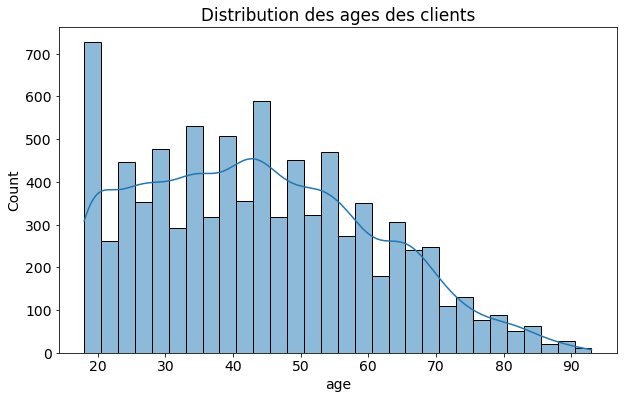

In [6]:
fig = plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 14})
sns.histplot(df_paniers['age'],kde=True)
plt.title("Distribution des ages des clients")
plt.show()
fig.savefig('./GRAPHIQUES/Correlation_age_MontantTotalAcha/Distribution des ages.png',dpi=fig.dpi*10)
plt.close(fig)

In [7]:
df_paniers['age'].describe()

count    8600.000000
mean       43.739302
std        16.908755
min        18.000000
25%        30.000000
50%        43.000000
75%        56.000000
max        93.000000
Name: age, dtype: float64

In [8]:
# shapiro-wilk test
# H0 : la distribution des ages suit une distribution normale
# H1 : la distribution des ages ne suit pas une distribution normale
res_shap=st.shapiro(df_paniers['age'])
print('statistic=%.3f, pvalue=%.3f' % (res_shap.statistic, res_shap.pvalue))

statistic=0.970, pvalue=0.000


C:\Users\yteki\AppData\Roaming\Python\Python39\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


La p-value (0.000 ) est nettement inferieure à 0.05 , on rejette donc l'hypothèse nulle au seuil de 5% . La distribution des ages ne suit donc pas une distribution normale .

In [9]:
# kolmogorov-smirnov
# H0 : la distribution des ages suit une distribution normale
# H1 : la distribution des ages ne suit pas une distribution normale
rng = np.random.default_rng()
sample2 = st.norm.rvs(size=342, random_state=rng)
res = st.ks_2samp(df_paniers['age'], sample2,alternative='two-sided')
print('statistic=%.3f, pvalue=%.3f' % (res.statistic, res.pvalue))

statistic=1.000, pvalue=0.000


La p-value (0.000 ) est nettement inferieure à 0.05 , on rejette donc l'hypothèse nulle au seuil de 5% . La distribution des ages ne suit donc pas une distribution normale .

### Normalite de la distribution des montants des achats

No handles with labels found to put in legend.


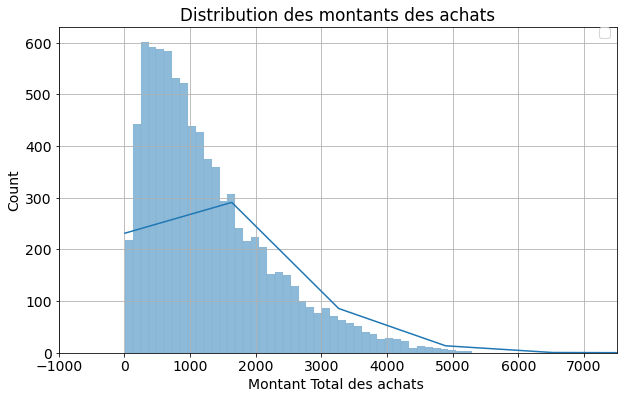

In [10]:
fig = plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 14})
sns.histplot(df_paniers['montant_totalAchat'],kde=True)
plt.xlabel('Montant Total des achats ')
plt.grid()
plt.xlim( -1000,7500)
plt.legend(bbox_to_anchor=(1, 1.02))
plt.title("Distribution des montants des achats")
plt.show()
fig.savefig('./GRAPHIQUES/Correlation_age_MontantTotalAcha/Distribution montant total des achats.png',dpi=fig.dpi*10)
plt.close(fig)

In [11]:
# shapiro-wilk test
# H0 : la distribution des montants de paniers suit une distribution normale
# H1 : la distribution des montants de paniers ne suit pas une distribution normale
res_shap=st.shapiro(df_paniers['montant_totalAchat'])
print('statistic=%.3f, pvalue=%.3f' % (res_shap.statistic, res_shap.pvalue))

statistic=0.061, pvalue=0.000


C:\Users\yteki\AppData\Roaming\Python\Python39\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


La p-value (0.000 ) est nettement inferieure à 0.05 , on rejette donc l'hypothèse nulle au seuil de 5% . La distribution des montants des paniers ne suit donc pas une distribution normale .

In [12]:
# kolmogorov-smirnov
# H0 : la distribution des montants de paniers suit une distribution normale
# H1 : la distribution des montants de paniers ne suit pas une distribution normale
rng = np.random.default_rng()
sample2 = st.norm.rvs(size=342, random_state=rng)
res = st.ks_2samp(df_paniers['montant_totalAchat'], sample2,alternative='two-sided')
print('statistic=%.3f, pvalue=%.3f' % (res.statistic, res.pvalue))

statistic=1.000, pvalue=0.000


La p-value (0.000 ) est nettement inferieure à 0.05 , on rejette donc l'hypothèse nulle au seuil de 5% . La distribution des montants des panier ne suit donc pas une distribution normale .

### TEST DE SPEARMAN

In [13]:
# Spearmanr correlation test
# H0 : les variables sont independantes
# H1 : les variables sont dependantes
res_spearman =st.spearmanr(df_paniers['age'],df_paniers['montant_totalAchat'])
print('correlation=%.3f, pvalue=%.3f' % (res_spearman.correlation, res_spearman.pvalue))

res_spearman

correlation=-0.185, pvalue=0.000


SpearmanrResult(correlation=-0.18494490728074367, pvalue=4.868785479534314e-67)

La p-value (0.000 ) est nettement inferieure à 0.05 , on rejette donc l'hypothèse nulle au seuil de 5% .
On conclue donc que l'Âge des clients et le montant total des achats sont 
##### dependantes .

In [14]:
slope, intercept, r_value, p_value, std_err = st.linregress(df_paniers['age'],
                                                            df_paniers['montant_totalAchat'])
fig = plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 14})

sns.scatterplot(data=df_paniers, x='age', y='montant_totalAchat')

plt.ylabel('Montant Total des achats')

plt.xlabel('Age')

plt.grid()

plt.xlim(15, 100)
plt.ylim(0, 6000)

plt.legend(bbox_to_anchor=(1, 1.02))

plt.title("Nuage de points age de client/montant total des achats")
fitLine = slope * df_paniers['age'] + intercept

plt.plot(df_paniers['age'], fitLine, c='r')
fig.savefig('./GRAPHIQUES/Correlation_age_MontantTotalAcha/Nuage_de_point_age_montanttotalachat.png',dpi=fig.dpi*10)
plt.close(fig)

No handles with labels found to put in legend.


In [15]:
# Eliminer les clients B2B
df_paniers = df_paniers[~df_paniers['client_id']\
                     .isin(['c_1609', 'c_4958', 'c_6714', 'c_3454'])]

In [16]:

slope, intercept, r_value, p_value, std_err = st.linregress(df_paniers['age'],
                                                            df_paniers['montant_totalAchat'])
fig = plt.figure(figsize=(10,6))
plt.plot(df_paniers['age'],df_paniers['montant_totalAchat'],'bo')
plt.xlabel("Âge")
plt.ylabel("montant_totalAchat Clients")
#la variable fitLine sera un tableau de valeurs prédites depuis la tableau de variables X
#fitLine = predict(df_paniers['age'])
fitLine = slope * df_paniers['age'] + intercept
plt.plot(df_paniers['age'], fitLine, c='r')
fig.savefig('./GRAPHIQUES/2Nuage_de_point_age_montanttotalachat.png',dpi=fig.dpi*10)
plt.close(fig)

### MERCI DE VOTRE ATTENTION